In [1]:
!pip install thop shapely umap-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is t

# Full Pipeline

In [2]:
import os, math, random, time, warnings
from collections import defaultdict
from pathlib import Path
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

try:
    from thop import profile
except Exception:
    profile = None
from sklearn.metrics import precision_recall_curve, average_precision_score

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

# -----------------------------
# Config
# -----------------------------
class CFG:
    BASE_PATH = "/kaggle/input/3dlidar"
    BIN_DIR   = "bin"
    LABEL_DIR = "label"
    CLASSES   = ['FTS', 'ELFplusplus', 'CargoBike', 'Box', 'ForkLift']
    NUM_POINTS = 4096
    SEED = 42

    # SSL
    FEAT_DIM = 128
    SSL_MASK_RATIO = 0.75
    SSL_KNN_GEO = 16
    SSL_BYOL_TAU = 0.996
    SSL_EPOCHS = 0  # Adjusted per session below
    SSL_BATCH_SIZE = 32
    SSL_LR = 1e-3
    SSL_SAVE_DIR = "/kaggle/working/ssl_point_coco_yolo"
    SSL_CKPT_PATH = os.path.join(SSL_SAVE_DIR, "ssl_full.pth")
    SSL_BACKBONE_PATH = os.path.join(SSL_SAVE_DIR, "ssl_backbone.pth")

    # Detection
    DET_EPOCHS = 10
    DET_BATCH_SIZE = 16
    DET_LR = 1e-3
    DET_WD = 1e-4
    DET_SAVE_DIR = "/kaggle/working/det_point_yolo"
    DET_MODEL_PATH = os.path.join(DET_SAVE_DIR, "best_detector.pth")

    # Eval/Training
    FP16 = torch.cuda.is_available()
    EVAL_CONF_THR = 0.10
    EVAL_NMS_THR = 0.45
    EVAL_IOU_THRESHOLDS = np.linspace(0.5, 0.95, 10)

os.makedirs(CFG.SSL_SAVE_DIR, exist_ok=True)
random.seed(CFG.SEED); np.random.seed(CFG.SEED); torch.manual_seed(CFG.SEED)
NUM_CLASSES = len(CFG.CLASSES)

# -----------------------------
# Geometry helpers
# -----------------------------
def rotz(yaw):
    c, s = math.cos(yaw), math.sin(yaw)
    return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]], np.float32)

def bev_poly(center, size, yaw):
    cx, cy = center[:2]; sx, sy = size[:2]
    pts = np.array([[-sx/2,-sy/2],[ sx/2,-sy/2],[ sx/2, sy/2],[-sx/2, sy/2]], np.float32)
    R = np.array([[math.cos(yaw), -math.sin(yaw)],[math.sin(yaw), math.cos(yaw)]])
    return (R @ pts.T).T + np.array([cx, cy])

def poly_iou(p1, p2):
    P1, P2 = Polygon(p1), Polygon(p2)
    if not P1.is_valid or not P2.is_valid: return 0.0
    inter = P1.intersection(P2).area
    union = P1.union(P2).area + 1e-6
    return float(inter / union)

def fast_bev_iou(b1, b2):
    # b = [cx, cy, cz, w, l, h, yaw] or similar; only uses x/y & w/l
    x1_min, x1_max = b1[0]-b1[3]/2, b1[0]+b1[3]/2
    y1_min, y1_max = b1[1]-b1[4]/2, b1[1]+b1[4]/2
    x2_min, x2_max = b2[0]-b2[3]/2, b2[0]+b2[3]/2
    y2_min, y2_max = b2[1]-b2[4]/2, b2[1]+b2[4]/2
    inter_x = max(0.0, min(x1_max, x2_max) - max(x1_min, x2_min))
    inter_y = max(0.0, min(y1_max, y2_max) - max(y1_min, y2_min))
    inter = inter_x * inter_y
    union = (b1[3]*b1[4] + b2[3]*b2[4] - inter) + 1e-6
    return inter / union

def yaw_loss(pred, gt):
    return (1.0 - torch.cos(pred - gt)).mean()

# -----------------------------
# Dataset helpers
# -----------------------------
def load_point_cloud(bin_path):
    arr = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    return arr[:, :3].astype(np.float32)

def parse_label_file(path):
    if not os.path.exists(path): return np.zeros((0,8), np.float32)
    out = []
    for ln in open(path).read().strip().splitlines():
        cls, x, y, z, sx, sy, sz, yaw = ln.strip().split()
        if cls not in CFG.CLASSES: continue
        out.append([CFG.CLASSES.index(cls), float(x), float(y), float(z), float(sx), float(sy), float(sz), float(yaw)])
    return np.array(out, np.float32) if out else np.zeros((0,8), np.float32)

def sample_pc(pc, n_points):
    if pc.shape[0] > n_points:
        return pc[np.random.choice(pc.shape[0], n_points, replace=False)]
    else:
        return pc[np.random.choice(pc.shape[0], n_points, replace=True)]

def augment_pc(pc):
    yaw = random.uniform(-math.pi/4, math.pi/4)
    pc = pc @ rotz(yaw).T
    scale = random.uniform(0.9, 1.1)
    pc = pc * scale
    jitter = np.random.normal(0, 0.01, pc.shape)
    pc = pc + jitter
    return pc.astype(np.float32)

def get_geometric_labels(pc, k=CFG.SSL_KNN_GEO):
    labels = np.full(pc.shape[0], 3, dtype=np.int64)
    if pc.shape[0] < k: return labels
    p_t = torch.from_numpy(pc).to(DEVICE)
    # compute pairwise distances (heavy but OK for precompute per-sample)
    with torch.no_grad():
        dist_matrix = torch.cdist(p_t, p_t, p=2)
        _, nn_idx = torch.topk(dist_matrix, k, dim=1, largest=False)
        nn_idx = nn_idx.cpu().numpy()
    for i in range(pc.shape[0]):
        neighbors = pc[nn_idx[i]]
        if neighbors.shape[0] < 3: continue
        neighbors_centered = neighbors - neighbors.mean(0)
        cov = (neighbors_centered.T @ neighbors_centered) / k
        try:
            eig_vals = np.linalg.eigvalsh(cov)
            eig_vals = np.sort(eig_vals)[::-1]
            if eig_vals[0] < 1e-6:
                labels[i] = 3
                continue
            eig_vals_norm = eig_vals / eig_vals[0]
            if eig_vals_norm[1] > 0.7:
                labels[i] = 0
            elif eig_vals_norm[1] < 0.3:
                labels[i] = 1
            else:
                labels[i] = 2
        except np.linalg.LinAlgError:
            labels[i] = 3
    return labels

# -----------------------------
# Checkpoint helpers
# -----------------------------
def save_ssl_checkpoint(model, opt, epoch, path_full=CFG.SSL_CKPT_PATH, path_backbone=CFG.SSL_BACKBONE_PATH):
    ckpt = {
        "epoch": epoch,
        "model_state_dict": model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        "optimizer_state_dict": opt.state_dict()
    }
    torch.save(ckpt, path_full)
    # save backbone-only for downstream loading
    backbone_sd = model.module.backbone.state_dict() if isinstance(model, nn.DataParallel) else model.backbone.state_dict()
    torch.save(backbone_sd, path_backbone)

def load_ssl_checkpoint(model, opt, path_full=CFG.SSL_CKPT_PATH):
    if os.path.exists(path_full):
        ckpt = torch.load(path_full, map_location=DEVICE)
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(ckpt["model_state_dict"])
        else:
            model.load_state_dict(ckpt["model_state_dict"])
        opt.load_state_dict(ckpt["optimizer_state_dict"])
        print(f"[SSL] Loaded checkpoint from {path_full} at epoch {ckpt['epoch']}")
        return ckpt["epoch"]
    else:
        print("[SSL] No checkpoint found, starting from scratch")
        return 0

def load_ssl_weights(model, backbone_path=CFG.SSL_BACKBONE_PATH):
    if os.path.exists(backbone_path):
        ssl_state = torch.load(backbone_path, map_location=DEVICE)
        try:
            # load into model.backbone if present, otherwise attempt to load into whole model (strict=False)
            if hasattr(model, "backbone"):
                model.backbone.load_state_dict(ssl_state, strict=False)
            else:
                model.load_state_dict(ssl_state, strict=False)
            print(f"[SSL] Loaded pre-trained backbone weights from {backbone_path}")
        except Exception as e:
            print("[SSL] Warning: failed to load backbone state dict cleanly:", e)
    else:
        print("[SSL] No pre-trained weights found at", backbone_path)

def save_detector_checkpoint(model, opt, epoch, val_loss, path=CFG.DET_MODEL_PATH):
    ckpt = {
        "epoch": epoch,
        "model_state_dict": model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
        "optimizer_state_dict": opt.state_dict(),
        "val_loss": val_loss
    }
    torch.save(ckpt, path)

# -----------------------------
# Models
# -----------------------------
class PointBackbone(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(3, 64), nn.ReLU(),
            nn.Linear(64, feat), nn.ReLU()
        )
        self.bn = nn.BatchNorm1d(feat)
    def forward(self, x):
        # x: (B,N,3) -> f: (B,N,feat)
        f = self.mlp(x)
        return self.bn(f.transpose(1,2)).transpose(1,2)

class ChamferDistance(nn.Module):
    def forward(self, p1, p2):
        # p1: (B,N,3) p2: (B,N,3)
        d1 = torch.cdist(p1, p2, p=2).min(2)[0]
        d2 = torch.cdist(p2, p1, p=2).min(2)[0]
        return (d1.mean() + d2.mean()) / 2.0

class PointCoCo(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM, num_geo=4):
        super().__init__()
        self.backbone = PointBackbone(feat)
        self.online_projector = nn.Sequential(nn.Linear(feat, feat*2), nn.ReLU(), nn.Linear(feat*2, feat))
        self.target_projector = nn.Sequential(nn.Linear(feat, feat*2), nn.ReLU(), nn.Linear(feat*2, feat))
        self.predictor = nn.Sequential(nn.Linear(feat, feat*2), nn.ReLU(), nn.Linear(feat*2, feat))
        self.decoder = nn.Sequential(nn.Linear(feat, feat*2), nn.ReLU(), nn.Linear(feat*2, feat*4), nn.ReLU(), nn.Linear(feat*4, CFG.NUM_POINTS * 3))
        self.geo_head = nn.Sequential(nn.Linear(feat, feat), nn.ReLU(), nn.Linear(feat, num_geo))
        # init target projector
        for o, t in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            t.data.copy_(o.data)
            t.requires_grad = False
        # target backbone for EMA
        self.target_backbone = PointBackbone(feat)
        self.target_backbone.load_state_dict(self.backbone.state_dict())
        for p in self.target_backbone.parameters():
            p.requires_grad = False

    def byol_loss(self, p_online, p_target):
        p_online_norm = F.normalize(p_online, dim=1)
        p_target_norm = F.normalize(p_target, dim=1)
        return 2.0 - 2.0 * (p_online_norm * p_target_norm).sum(dim=1).mean()

    @torch.no_grad()
    def update_target(self):
        tau = CFG.SSL_BYOL_TAU
        for o, t in zip(self.online_projector.parameters(), self.target_projector.parameters()):
            t.data.mul_(tau).add_(o.data, alpha=1 - tau)
        for o, t in zip(self.backbone.parameters(), self.target_backbone.parameters()):
            t.data.mul_(tau).add_(o.data, alpha=1 - tau)

    def forward(self, unmasked_idx, pc_aug1, pc_aug2):
        B, N, C = pc_aug1.shape
        pc_unmasked = torch.gather(pc_aug1, 1, unmasked_idx.unsqueeze(-1).expand(-1, -1, 3))
        f_unmasked = self.backbone(pc_unmasked)                 # (B, M, feat)
        geo_pred = self.geo_head(f_unmasked)                    # (B, M, num_geo)
        f_global = f_unmasked.max(1)[0]                         # (B, feat)
        pc_recon = self.decoder(f_global).view(B, N, 3)         # (B,N,3)
        p_online = self.predictor(self.online_projector(f_global))
        with torch.no_grad():
            f_aug2_global = self.target_backbone(pc_aug2).max(1)[0]
            p_target = self.target_projector(f_aug2_global)
        return p_online, p_target, pc_recon, geo_pred

class YOLO3DHead(nn.Module):
    def __init__(self, feat=CFG.FEAT_DIM, num_classes=NUM_CLASSES):
        super().__init__()
        self.pred = nn.Sequential(nn.Linear(feat, feat), nn.ReLU(), nn.Linear(feat, 7 + 1 + num_classes))
    def forward(self, f): return self.pred(f)

class YOLO3D(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES, feat_dim=CFG.FEAT_DIM):
        super().__init__()
        self.backbone = PointBackbone(feat_dim)
        self.head = YOLO3DHead(feat=feat_dim, num_classes=num_classes)
    def forward(self, pc):
        f = self.backbone(pc)      # (B,N,feat)
        pred = self.head(f)        # (B,N,7+1+num_classes)
        return pred

# -----------------------------
# Dataset classes
# -----------------------------
class SSLDataset(Dataset):
    def __init__(self, base, idxs, is_val=False):
        self.base = base
        self.bin_dir = os.path.join(base, CFG.BIN_DIR)
        files = sorted([f for f in os.listdir(self.bin_dir) if f.endswith(".bin")])
        self.files = [files[i] for i in idxs]
        self.is_val = is_val
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        f = self.files[i]
        pc = load_point_cloud(os.path.join(self.bin_dir, f))
        pc = sample_pc(pc, CFG.NUM_POINTS)
        pc_aug1 = augment_pc(pc.copy()) if not self.is_val else pc.copy()
        pc_aug2 = augment_pc(pc.copy()) if not self.is_val else pc.copy()
        geo_labels = get_geometric_labels(pc)
        return torch.from_numpy(pc).float(), torch.from_numpy(pc_aug1).float(), torch.from_numpy(pc_aug2).float(), torch.from_numpy(geo_labels).long()

def collate_ssl(b):
    pc, pc1, pc2, geo = zip(*b)
    return torch.stack(pc), torch.stack(pc1), torch.stack(pc2), torch.stack(geo)

class DetDataset(Dataset):
    def __init__(self, base, idxs, augment=False):
        self.base = base
        self.bin_dir = os.path.join(base, CFG.BIN_DIR)
        self.lab_dir = os.path.join(base, CFG.LABEL_DIR)
        files = sorted([f for f in os.listdir(self.bin_dir) if f.endswith(".bin")])
        self.files = [files[i] for i in idxs]
        self.augment = augment
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        f = self.files[i]
        pc = load_point_cloud(os.path.join(self.bin_dir, f)); pc = sample_pc(pc, CFG.NUM_POINTS)
        gts = parse_label_file(os.path.join(self.lab_dir, f.replace(".bin", ".txt")))
        if self.augment:
            yaw = random.uniform(-math.pi/6, math.pi/6)
            R = rotz(yaw)
            pc = pc @ R.T
            if len(gts) > 0:
                for row in gts:
                    row[1:4] = (R @ row[1:4].copy().reshape(3,1)).reshape(3,)
                    row[7] += yaw
        return torch.from_numpy(pc).float(), torch.from_numpy(gts).float()

def collate_det(b): pcs, gts = zip(*b); return torch.stack(pcs, 0), list(gts)

# -----------------------------
# Losses & training steps
# -----------------------------
def _unwrap_model(model):
    return model.module if isinstance(model, nn.DataParallel) else model

def ssl_loss(p_online, p_target, pc_recon, geo_pred, pc_full, geo_labels_unmasked, model):
    """
    Compute combined SSL loss. Unwrap DataParallel to call module-level methods.
    """
    real_model = _unwrap_model(model)
    l_con = real_model.byol_loss(p_online, p_target)
    l_rec = ChamferDistance()(pc_recon, pc_full)
    l_geo = F.cross_entropy(geo_pred.transpose(1,2), geo_labels_unmasked)
    loss = l_con + l_rec + l_geo
    parts = {'con': l_con.item(), 'rec': l_rec.item(), 'geo': l_geo.item()}
    return loss, parts

def run_ssl_epoch(model, loader, opt, scaler, pbar):
    model.train()
    running_loss = 0.0
    real_model = _unwrap_model(model)
    for pc_full, pc_aug1, pc_aug2, geo_labels in loader:
        pc_full = pc_full.to(DEVICE); pc_aug1 = pc_aug1.to(DEVICE); pc_aug2 = pc_aug2.to(DEVICE); geo_labels = geo_labels.to(DEVICE)
        B, N, _ = pc_full.shape
        M = int(N * (1 - CFG.SSL_MASK_RATIO))
        # choose unmasked (kept) indices
        perm = torch.randperm(N)[:M].to(DEVICE)
        unmasked_idx = perm.unsqueeze(0).expand(B, -1)
        geo_unmasked = torch.gather(geo_labels, 1, unmasked_idx)
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            p_online, p_target, pc_recon, geo_pred = model(unmasked_idx, pc_aug1, pc_aug2)
            loss, parts = ssl_loss(p_online, p_target, pc_recon, geo_pred, pc_full, geo_unmasked, model)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        # update EMA target using the underlying module
        real_model.update_target()
        running_loss += loss.item()
        pbar.update(1)
        pbar.set_postfix(loss=loss.item(), **parts)
    return running_loss / max(1, len(loader))

@torch.no_grad()
def val_ssl_epoch(model, loader, pbar):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    n_samples = 0
    for pc_full, pc_aug1, pc_aug2, geo_labels in loader:
        pc_full = pc_full.to(DEVICE); pc_aug1 = pc_aug1.to(DEVICE); pc_aug2 = pc_aug2.to(DEVICE); geo_labels = geo_labels.to(DEVICE)
        B, N, _ = pc_full.shape
        M = int(N * (1 - CFG.SSL_MASK_RATIO))
        perm = torch.randperm(N)[:M].to(DEVICE)
        unmasked_idx = perm.unsqueeze(0).expand(B, -1)
        geo_unmasked = torch.gather(geo_labels, 1, unmasked_idx)
        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            p_online, p_target, pc_recon, geo_pred = model(unmasked_idx, pc_aug1, pc_aug2)
            loss, _ = ssl_loss(p_online, p_target, pc_recon, geo_pred, pc_full, geo_unmasked, model)
        running_loss += loss.item()
        pred_cls = geo_pred.argmax(dim=2)
        running_acc += (pred_cls == geo_unmasked).sum().item()
        n_samples += geo_unmasked.numel()
        pbar.update(1)
        pbar.set_postfix(loss=loss.item())
    return running_loss / max(1, len(loader)), running_acc / max(1, n_samples)

def yolo3d_loss(pred, gt_list):
    B, N, C = pred.shape
    loss_box = loss_conf = loss_cls = 0.0
    n_pos = 0
    for b in range(B):
        gt = gt_list[b].to(pred.device)
        pbox = pred[b, :, :7]
        conf = pred[b, :, 7]
        pcls = pred[b, :, 8:]
        if gt.numel() == 0:
            loss_conf += F.binary_cross_entropy_with_logits(conf, torch.zeros_like(conf))
            continue
        pos_mask = torch.zeros(N, dtype=torch.bool, device=pred.device)
        for g in gt:
            cls = int(g[0].item())
            d = torch.norm(pbox[:, :3] - g[1:4], dim=1)
            min_id = torch.argmin(d)
            pos_mask[min_id] = True
            loss_box += F.smooth_l1_loss(pbox[min_id, :6], g[1:7])
            loss_box += yaw_loss(pbox[min_id, 6], g[7])
            loss_conf += F.binary_cross_entropy_with_logits(conf[min_id], torch.ones((), device=pred.device))
            loss_cls += F.cross_entropy(pcls[min_id].unsqueeze(0), torch.tensor([cls], device=pred.device))
            n_pos += 1
        if (~pos_mask).sum() > 0:
            loss_conf += F.binary_cross_entropy_with_logits(conf[~pos_mask], torch.zeros_like(conf[~pos_mask]))
    denom = max(1, n_pos)
    total = (loss_box + loss_conf + loss_cls) / denom
    return total, {"box": float(loss_box/denom), "conf": float(loss_conf/denom), "cls": float(loss_cls/denom)}

def run_det_epoch(model, loader, opt, scaler, pbar):
    model.train()
    running_loss = 0.0
    for pc, gt_list in loader:
        pc = pc.to(DEVICE)
        opt.zero_grad()
        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            out = model(pc)
            loss, parts = yolo3d_loss(out, gt_list)
        scaler.scale(loss).backward()
        scaler.unscale_(opt)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(opt); scaler.update()
        running_loss += loss.item()
        pbar.update(1)
        pbar.set_postfix(loss=f"{loss.item():.4f}", **parts)
    return running_loss / max(1, len(loader))

@torch.no_grad()
def run_det_val(model, loader, pbar):
    model.eval()
    running = []
    for pc, gt_list in loader:
        pc = pc.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=CFG.FP16):
            out = model(pc)
            loss, _ = yolo3d_loss(out, gt_list)
        running.append(loss.item())
        pbar.update(1)
        pbar.set_postfix(loss=loss.item())
    return float(np.mean(running)) if running else 0.0

# -----------------------------
# SSL Training (with curves)
# -----------------------------
def train_ssl(plot_curve=True):
    base = CFG.BASE_PATH
    files = sorted([f for f in os.listdir(os.path.join(base, CFG.BIN_DIR)) if f.endswith(".bin")])
    idxs = np.arange(len(files)); np.random.shuffle(idxs)
    n_val = int(0.2 * len(files))
    val_idx, train_idx = idxs[:n_val], idxs[n_val:]
    train_ds = SSLDataset(base, train_idx, is_val=False)
    val_ds = SSLDataset(base, val_idx, is_val=True)
    train_dl = DataLoader(train_ds, batch_size=CFG.SSL_BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_ssl)
    val_dl = DataLoader(val_ds, batch_size=CFG.SSL_BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_ssl)

    model = PointCoCo().to(DEVICE)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    opt = torch.optim.AdamW(model.parameters(), lr=CFG.SSL_LR)
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.FP16)

    # Load checkpoint if exists for resuming
    start_epoch = load_ssl_checkpoint(model, opt) + 1

    best_acc = 0.0
    train_losses = []
    val_losses = []
    val_accs = []

    for ep in range(start_epoch, CFG.SSL_EPOCHS + 1):
        pbar_train = tqdm(total=len(train_dl), desc=f"[SSL {ep}/{CFG.SSL_EPOCHS}] Train")
        train_loss = run_ssl_epoch(model, train_dl, opt, scaler, pbar_train)
        pbar_train.close()
        train_losses.append(train_loss)

        pbar_val = tqdm(total=len(val_dl), desc=f"[SSL {ep}/{CFG.SSL_EPOCHS}] Val")
        val_loss, val_acc = val_ssl_epoch(model, val_dl, pbar_val)
        pbar_val.close()
        val_losses.append(val_loss); val_accs.append(val_acc)

        print(f"[SSL Epoch {ep:02d}] Train Loss={train_loss:.4f} Val Loss={val_loss:.4f} GeoAcc={val_acc:.4f}")

        # Save full ckpt + backbone (overwrite for resuming)
        save_ssl_checkpoint(model, opt, ep)

        # Save if best
        if val_acc > best_acc:
            best_acc = val_acc
            best_path_full = os.path.join(CFG.SSL_SAVE_DIR, "best_ssl_full.pth")
            best_path_backbone = os.path.join(CFG.SSL_SAVE_DIR, "best_ssl_backbone.pth")
            save_ssl_checkpoint(model, opt, ep, best_path_full, best_path_backbone)
            print(f"  -> Saved best SSL checkpoint + backbone (GeoAcc={best_acc:.4f})")

    # plot curves
    if plot_curve:
        plt.figure(figsize=(10,4))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.title("SSL Training Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
        plt.savefig(os.path.join(CFG.SSL_SAVE_DIR, "ssl_loss_curve.png"))
        plt.show()

        plt.figure(figsize=(8,4))
        plt.plot(val_accs, label="Geo Acc (val)")
        plt.title("SSL Geo Accuracy (validation)")
        plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)
        plt.savefig(os.path.join(CFG.SSL_SAVE_DIR, "ssl_geo_acc.png"))
        plt.show()

    return os.path.exists(CFG.SSL_CKPT_PATH)

# Session 01: [Epoch 1 - 30]

In [3]:
# # Session 1 Code
# CFG.SSL_EPOCHS = 30
# train_ssl()

# Session 02: [Epoch 31 - 50]

In [4]:
# # Session 2 Code
# CFG.SSL_EPOCHS = 50
# import shutil
# PREV_CKPT_DATASET = "/kaggle/input/ssl-checkpoints-epoch30"
# PREV_CKPT_DIR = os.path.join(PREV_CKPT_DATASET, "ssl_point_coco_yolo")
# if os.path.exists(PREV_CKPT_DIR):
#     shutil.copy(os.path.join(PREV_CKPT_DIR, "ssl_full.pth"), CFG.SSL_CKPT_PATH)
#     shutil.copy(os.path.join(PREV_CKPT_DIR, "ssl_backbone.pth"), CFG.SSL_BACKBONE_PATH)
#     print(f"Copied checkpoints from {PREV_CKPT_DIR} for resuming")
# train_ssl()

# Session 03: [Epoch 51 - 70]

In [5]:
# # Session 3 Code
# CFG.SSL_EPOCHS = 70
# import shutil
# PREV_CKPT_DATASET = "/kaggle/input/ssl-checkpoints-epoch50"
# PREV_CKPT_DIR = os.path.join(PREV_CKPT_DATASET, "ssl_point_coco_yolo")
# if os.path.exists(PREV_CKPT_DIR):
#     shutil.copy(os.path.join(PREV_CKPT_DIR, "ssl_full.pth"), CFG.SSL_CKPT_PATH)
#     shutil.copy(os.path.join(PREV_CKPT_DIR, "ssl_backbone.pth"), CFG.SSL_BACKBONE_PATH)
#     print(f"Copied checkpoints from {PREV_CKPT_DIR} for resuming")
# train_ssl()

# Session 04: [Epoch 71 - 100]

Copied checkpoints from /kaggle/input/ssl-checkpoint-epoch70/ssl_point_coco_yolo for resuming
[SSL] Loaded checkpoint from /kaggle/working/ssl_point_coco_yolo/ssl_full.pth at epoch 70


[SSL 71/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 71/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 71] Train Loss=1.3570 Val Loss=1.3312 GeoAcc=0.6232
  -> Saved best SSL checkpoint + backbone (GeoAcc=0.6232)


[SSL 72/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 72/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 72] Train Loss=1.3452 Val Loss=1.3317 GeoAcc=0.6225


[SSL 73/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 73/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 73] Train Loss=1.3477 Val Loss=1.3207 GeoAcc=0.6211


[SSL 74/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 74/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 74] Train Loss=1.3443 Val Loss=1.3201 GeoAcc=0.6211


[SSL 75/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 75/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 75] Train Loss=1.3532 Val Loss=1.3184 GeoAcc=0.6217


[SSL 76/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 76/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 76] Train Loss=1.3414 Val Loss=1.3127 GeoAcc=0.6209


[SSL 77/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 77/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 77] Train Loss=1.3459 Val Loss=1.2900 GeoAcc=0.6226


[SSL 78/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 78/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 78] Train Loss=1.3395 Val Loss=1.3141 GeoAcc=0.6213


[SSL 79/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 79/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 79] Train Loss=1.3373 Val Loss=1.3122 GeoAcc=0.6219


[SSL 80/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 80/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 80] Train Loss=1.3454 Val Loss=1.3129 GeoAcc=0.6210


[SSL 81/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 81/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 81] Train Loss=1.3417 Val Loss=1.3046 GeoAcc=0.6231


[SSL 82/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 82/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 82] Train Loss=1.3406 Val Loss=1.3086 GeoAcc=0.6206


[SSL 83/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 83/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 83] Train Loss=1.3386 Val Loss=1.3066 GeoAcc=0.6214


[SSL 84/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 84/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 84] Train Loss=1.3363 Val Loss=1.3436 GeoAcc=0.6222


[SSL 85/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 85/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 85] Train Loss=1.3426 Val Loss=1.3042 GeoAcc=0.6229


[SSL 86/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 86/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 86] Train Loss=1.3402 Val Loss=1.3152 GeoAcc=0.6238
  -> Saved best SSL checkpoint + backbone (GeoAcc=0.6238)


[SSL 87/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 87/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 87] Train Loss=1.3359 Val Loss=1.3190 GeoAcc=0.6193


[SSL 88/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 88/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 88] Train Loss=1.3391 Val Loss=1.3264 GeoAcc=0.6227


[SSL 89/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 89/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 89] Train Loss=1.3475 Val Loss=1.3152 GeoAcc=0.6236


[SSL 90/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 90/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 90] Train Loss=1.3301 Val Loss=1.2881 GeoAcc=0.6234


[SSL 91/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 91/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 91] Train Loss=1.3422 Val Loss=1.3023 GeoAcc=0.6218


[SSL 92/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 92/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 92] Train Loss=1.3399 Val Loss=1.3194 GeoAcc=0.6216


[SSL 93/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 93/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 93] Train Loss=1.3387 Val Loss=1.3057 GeoAcc=0.6225


[SSL 94/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 94/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 94] Train Loss=1.3500 Val Loss=1.3646 GeoAcc=0.6218


[SSL 95/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 95/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 95] Train Loss=1.3339 Val Loss=1.3062 GeoAcc=0.6241
  -> Saved best SSL checkpoint + backbone (GeoAcc=0.6241)


[SSL 96/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 96/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 96] Train Loss=1.3371 Val Loss=1.3293 GeoAcc=0.6217


[SSL 97/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 97/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 97] Train Loss=1.3308 Val Loss=1.3145 GeoAcc=0.6240


[SSL 98/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 98/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 98] Train Loss=1.3253 Val Loss=1.3220 GeoAcc=0.6201


[SSL 99/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 99/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 99] Train Loss=1.3427 Val Loss=1.3137 GeoAcc=0.6235


[SSL 100/100] Train:   0%|          | 0/83 [00:00<?, ?it/s]

[SSL 100/100] Val:   0%|          | 0/21 [00:00<?, ?it/s]

[SSL Epoch 100] Train Loss=1.3313 Val Loss=1.3017 GeoAcc=0.6215


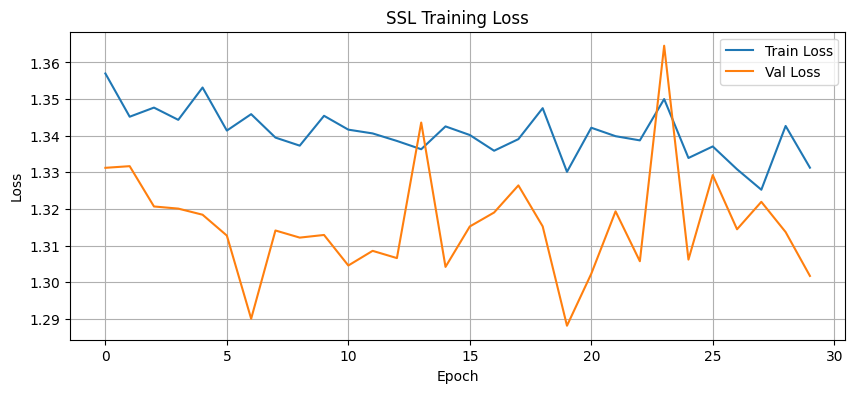

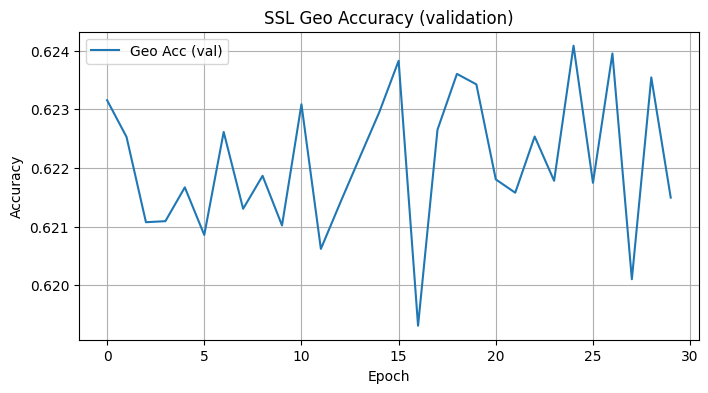

True

In [6]:
# Session 4 Code
CFG.SSL_EPOCHS = 100
import shutil
PREV_CKPT_DATASET = "/kaggle/input/ssl-checkpoint-epoch70"
PREV_CKPT_DIR = os.path.join(PREV_CKPT_DATASET, "ssl_point_coco_yolo")
if os.path.exists(PREV_CKPT_DIR):
    shutil.copy(os.path.join(PREV_CKPT_DIR, "ssl_full.pth"), CFG.SSL_CKPT_PATH)
    shutil.copy(os.path.join(PREV_CKPT_DIR, "ssl_backbone.pth"), CFG.SSL_BACKBONE_PATH)
    print(f"Copied checkpoints from {PREV_CKPT_DIR} for resuming")
train_ssl()